In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/MA_Putusan/CSV/dataset_putusan_final.csv")
df["ringkasan_fakta"] = df["ringkasan_fakta"].fillna("")

# --- Pastikan kolom penting tersedia ---
assert "case_id" in df.columns and "ringkasan_fakta" in df.columns, "Dataset harus memiliki kolom 'case_id' dan 'ringkasan_fakta'."

# --- TF-IDF Vectorizer ---
stopwords_id = ['yang', 'dan', 'di', 'ke', 'dengan', 'adalah', 'untuk', 'dalam', 'tidak', 'oleh', 'atau']
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords_id)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["ringkasan_fakta"])

# --- BERT Tokenizer + Model ---
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# --- Retrieve Function ---
def retrieve(query: str, k: int = 5, method: str = "tfidf", exclude_case_id=None) -> list:
    query = query.strip()
    if method == "tfidf":
        query_vec = tfidf_vectorizer.transform([query])
        scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    elif method == "bert":
        query_vec = get_bert_embedding(query).reshape(1, -1)
        doc_vectors = np.array([get_bert_embedding(doc) for doc in df["ringkasan_fakta"]])
        scores = cosine_similarity(query_vec, doc_vectors).flatten()
    else:
        raise ValueError("method harus 'tfidf' atau 'bert'.")

    if exclude_case_id is not None:
        mask = df["case_id"] != exclude_case_id
        scores = scores[mask]
        ids = df[mask]["case_id"].values
    else:
        ids = df["case_id"].values

    top_indices = scores.argsort()[::-1][:k]
    return [ids[i] for i in top_indices]


In [18]:
import os
import json

# --- Mapping solusi dari dataset ---
case_solutions = pd.Series(df["ringkasan_fakta"].values, index=df["case_id"]).to_dict()

# --- Fungsi Prediksi Solusi ---
def predict_outcome(query: str, query_case_id: int = None, method="tfidf", k=5) -> dict:
    top_k = retrieve(query, k=k, method=method, exclude_case_id=query_case_id)
    solutions = [case_solutions.get(cid, "") for cid in top_k]
    counter = Counter(solutions)
    predicted_solution = counter.most_common(1)[0][0] if counter else "Tidak ditemukan"
    return {
        "query": query,
        "predicted_solution": predicted_solution,
        "top_k_case_ids": top_k
    }

# --- Ambil sample query dari dataset ---
sample_queries = df.sample(n=5, random_state=42)[["case_id", "ringkasan_fakta"]].reset_index(drop=True)

results = []
queries = []

for _, row in sample_queries.iterrows():
    qid = int(row["case_id"])
    text = row["ringkasan_fakta"]
    true_sol = case_solutions[qid]

    pred = predict_outcome(text, query_case_id=qid, method="tfidf")

    results.append({
        "Query ID": qid,
        "Query (Ringkasan)": text[:100] + "...",
        "Predicted Solution": pred["predicted_solution"][:100] + "...",
        "Top-5 Case IDs": pred["top_k_case_ids"]
    })

    queries.append({
        "query_id": qid,
        "text": text,
        "true_solution": true_sol
    })

# --- Simpan Hasil ke File ---
output_dir = "/content/drive/MyDrive/MA_Putusan/Hasil"
os.makedirs(output_dir, exist_ok=True)

pd.DataFrame(results).to_csv(f"{output_dir}/predictions.csv", index=False)
with open(f"{output_dir}/queries.json", "w") as f:
    json.dump(queries, f, indent=2)

# --- Tampilkan Tabel di Output Cell ---
pd.DataFrame(results)


,Query ID,Query (Ringkasan),Predicted Solution,Top-5 Case IDs
0,34,Terdakwa diajukan ke persidangan oleh Penuntut...,Terdakwa diajukan ke persidangan oleh Penuntut...,"[188, 88, 123, 187, 178]"
1,7,Terdakwa diajukan ke persidangan oleh Penuntut...,Terdakwa diajukan ke persidangan oleh Penuntut...,"[121, 115, 127, 94, 122]"
2,182,Terdakwa diajukan ke persidangan oleh Penuntut...,Terdakwa diajukan ke persidangan oleh Penuntut...,"[208, 148, 137, 147, 202]"
3,87,Terdakwa diajukan ke persidangan oleh Penuntut...,Terdakwa diajukan ke persidangan oleh Penuntut...,"[113, 71, 84, 125, 100]"
4,156,Terdakwa diajukan ke persidangan oleh Penuntut...,Terdakwa diajukan ke persidangan oleh Pen...,"[131, 195, 202, 189, 143]"


In [22]:
!pip install -U imbalanced-learn


In [38]:
!pip install -U sentence-transformers

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split


In [54]:
# STEP 2: Load Dataset
df = pd.read_csv('/content/drive/MyDrive/MA_Putusan/CSV/dataset_putusan_final.csv')
df = df.dropna(subset=['ringkasan_fakta', 'pasal']).drop_duplicates(subset=['ringkasan_fakta'])

def clean_pasal(pasal):
    return pasal.lower().replace('kuhp', '').replace('.', '').strip()

df['pasal_clean'] = df['pasal'].astype(str).apply(clean_pasal)


In [55]:
# STEP 3: Filter pasal yang muncul > 1 kali
pasal_counts = df['pasal_clean'].value_counts()
popular_pasals = pasal_counts[pasal_counts > 1].index.tolist()

df = df[df['pasal_clean'].isin(popular_pasals)].reset_index(drop=True)
print("Jumlah data setelah filter pasal populer:", len(df))


Jumlah data setelah filter pasal populer: 14


In [56]:
# Tambahan Cek agar tidak error
if len(df) < 5:
    raise ValueError("❌ Dataset terlalu kecil setelah filtering. Gunakan threshold lebih rendah atau periksa dataset.")


In [57]:
# STEP 4: Split data
corpus_df, query_df = train_test_split(df, test_size=0.2, random_state=42)
corpus_df = corpus_df.reset_index(drop=True)
query_df = query_df.sample(n=min(100, len(query_df)), random_state=42).reset_index(drop=True)


In [58]:
# STEP 5: Load SBERT
model = SentenceTransformer('indobenchmark/indobert-base-p1')


In [59]:
# STEP 6: Encode Corpus
corpus_embeddings = model.encode(
    corpus_df['ringkasan_fakta'].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
# STEP 7: Retrieval Evaluasi
top_k = 5
hits, ranks = [], []

for i, row in query_df.iterrows():
    query_text = row['ringkasan_fakta']
    query_label = row['pasal_clean']

    query_embedding = model.encode(query_text, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_indices = torch.topk(similarities, k=top_k).indices.cpu().tolist()
    retrieved_labels = corpus_df.iloc[top_indices]['pasal_clean'].tolist()

    # Hit@5 dan Reciprocal Rank
    hits.append(query_label in retrieved_labels)
    rr = 0
    for rank, label in enumerate(retrieved_labels, start=1):
        if label == query_label:
            rr = 1 / rank
            break
    ranks.append(rr)

query_df['Hit@5'] = hits
query_df['ReciprocalRank'] = ranks


In [61]:
# STEP 8: Evaluasi
acc = query_df['Hit@5'].mean()
mrr = query_df['ReciprocalRank'].mean()

print(f"✅ Top-5 Retrieval Accuracy: {acc:.2%}")
print(f"✅ Mean Reciprocal Rank (MRR): {mrr:.4f}")


✅ Top-5 Retrieval Accuracy: 100.00%
✅ Mean Reciprocal Rank (MRR): 0.4667


<ipython-input-62-4c37341beea0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=query_df, x='Hit@5', palette='Set2')


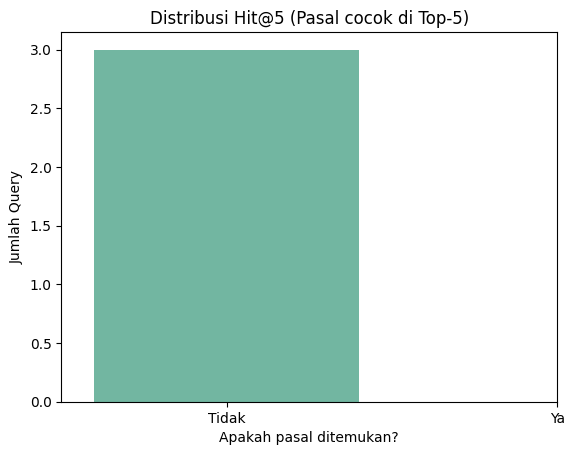

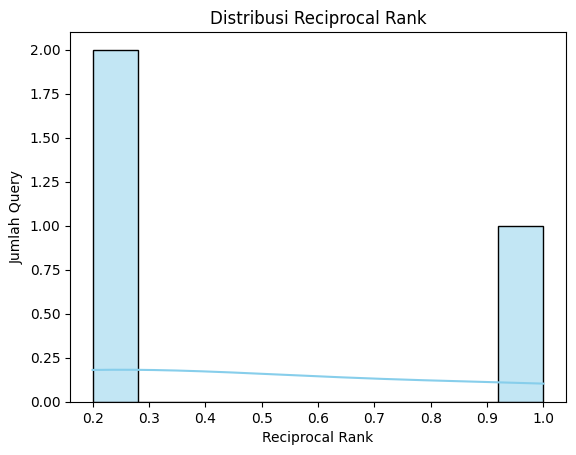

In [62]:
# STEP 9: Visualisasi
sns.countplot(data=query_df, x='Hit@5', palette='Set2')
plt.title('Distribusi Hit@5 (Pasal cocok di Top-5)')
plt.xticks([0, 1], ['Tidak', 'Ya'])
plt.xlabel('Apakah pasal ditemukan?')
plt.ylabel('Jumlah Query')
plt.show()

sns.histplot(data=query_df, x='ReciprocalRank', bins=10, kde=True, color='skyblue')
plt.title('Distribusi Reciprocal Rank')
plt.xlabel('Reciprocal Rank')
plt.ylabel('Jumlah Query')
plt.show()
